In [36]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import cmasher
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
import vorbin
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')
import jax


In [37]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 

In [38]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_catalogo_14_mayo.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb2 = fits.open(path+file)
data2 = tb2[1].data
gc_star_ids = data2.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids))+' GC stars')

# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_members_VAC.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb3 = fits.open(path+file)
data3 = tb3[1].data
gc_star_ids_RPS = data3.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids_RPS))+' GC stars')

There are 7562 GC stars
There are 7260 GC stars


In [39]:
apo_id = data['APOGEE_ID']
# Clean the initial data
mask_gcs = np.isin(list(apo_id),list(gc_star_ids))
mask_gcs2 = np.isin(list(apo_id),list(gc_star_ids_RPS))

In [40]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()


526130

In [41]:
aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

536568

In [42]:
# create the parent mask
mask = (data['SNR']>50)&(data['LOGG']<3.5)&(data['LOGG']>1.5)&(data['TEFF']>3500.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(mask_gcs2==False)&(starflag_mask)&(aspcapflag_mask)
# &(data['ruwe']<1.4)

print('There are '+str(len(data[mask]))+' stars in the parent sample')



There are 248945 stars in the parent sample


Check the distances

(0.0, 1.0)

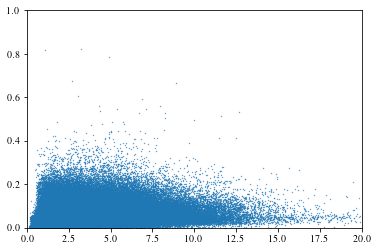

In [8]:
dist= data['dist50']
dist_err = (data['dist84']-data['dist16'])/2.

plt.scatter(dist[mask],dist_err[mask]/dist[mask],s=0.1)
plt.xlim(0,20)
plt.ylim(0,1)

#distances for parent sample are within 20% error so all good

In [43]:
line = data['FE_H']*-0.167 + 0.12
lowa_disc_mask = ((data['FE_H']>-0.8)&(data['FE_H']<-0.4)&(data['MG_FE']<0.185))|((data['FE_H']>-0.4)&(data['FE_H']<-0.05)&(data['MG_FE']<line))|((data['FE_H']>-0.05)&(data['FE_H']<0.6)&(data['MG_FE']<0.12))


higha_disc_mask_strict = ((data['FE_H']>-1)&(data['FE_H']<-0.4)&(data['MG_FE']>line))|\
((data['FE_H']>-0.4)&(data['FE_H']<0.6)&(data['MG_FE']>0.185))

higha_disc_mask = ((data['FE_H']>-1)&(data['FE_H']<0.)&(data['MG_FE']>line))|((data['FE_H']>0.)&(data['FE_H']<0.6)&(data['MG_FE']>0.12))


inta_disc_mask = ((data['FE_H']>-0.4)&(data['FE_H']<-0.0)&(data['MG_FE']>line)&(data['MG_FE']<0.22))|((data['FE_H']>0.0)&(data['FE_H']<0.6)&(data['MG_FE']>0.12)&(data['MG_FE']<0.22))

other_mask = (~higha_disc_mask)&(~lowa_disc_mask)&(data['FE_H']<-0.8)


In [10]:
print(len(data[mask&lowa_disc_mask]))
np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/sav/lowa_mask',mask&lowa_disc_mask)

172656


In [44]:
import astropy.units as u
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vx = data['vxyz'][:,0]
vy = data['vxyz'][:,1]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(Rgal-8.275)
Rg = -(data['L'][:,2]/vcirc)
deltaR = Rgal-Rg
phi = np.arctan(data['xyz'][:,1]/data['xyz'][:,0])

#transform to cylindrical velocities
vr = +data['vxyz'][:,0]*np.cos(phi)+data['vxyz'][:,1]*np.sin(phi)
vt = -data['vxyz'][:,0]*np.sin(phi)+data['vxyz'][:,1]*np.cos(phi)


lowa = mask&lowa_disc_mask

# so that we can apply OTI, we need to have some good approximation to circular orbits that are decomposable in R and z
omask = (np.abs(z)<2*u.kpc)&(np.abs(vz)<80*u.kpc/u.Gyr)&(np.abs(deltaR)<1)&(np.abs(vr)<50) # vr of 50 here caused we checked deltaR in Vr and found it is around 50
lowa_omask = lowa&omask

print('There are '+str(len(data[lowa]))+' stars in the parent sample')
print('There are '+str(len(data[lowa_omask]))+' stars in the sample we model')



There are 172656 stars in the parent sample
There are 94685 stars in the sample we model


In [45]:
from matplotlib.colors import LogNorm


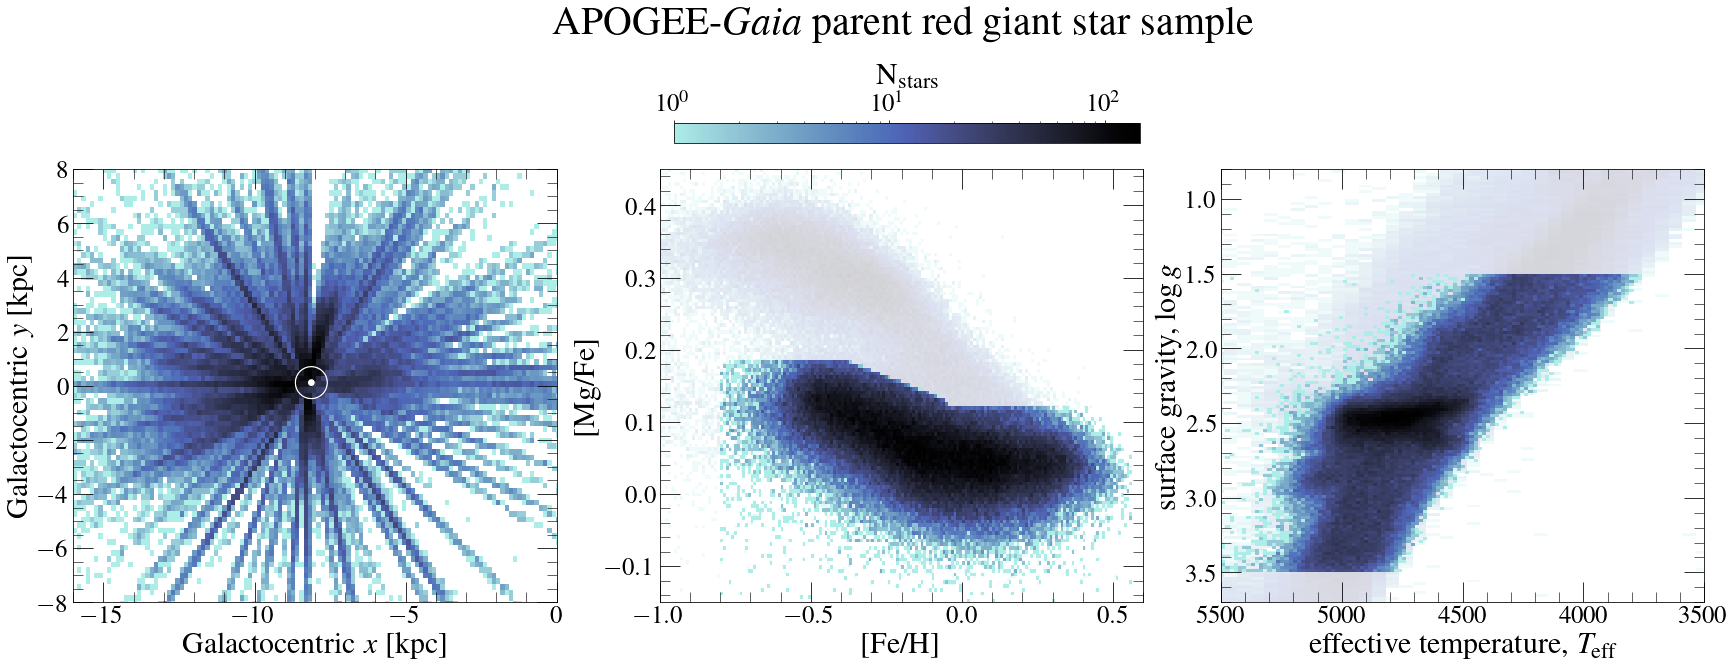

In [47]:
## from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(24,7),constrained_layout=True,facecolor='white')
fig.suptitle('APOGEE-$Gaia$ parent red giant star sample',fontsize=40,x=0.52,y=1.3)

plt.subplot(1,3,1)
plt.hist2d(data['xyz'][:,0][mask&lowa_disc_mask],data['xyz'][:,1][mask&lowa_disc_mask],bins=300,cmap=cmasher.sapphire_r,norm=LogNorm(),rasterized=True)
# plt.scatter(-8.125,0.,c='white',s=100)
plt.text(-8.7,-0.35,'$\odot$',fontsize=50,color='white',fontweight='bold')
plt.xlabel('Galactocentric $x$ [kpc]', fontsize=30)
plt.ylabel('Galactocentric $y$ [kpc]', fontsize=30)
plt.xlim(-16,0)
plt.ylim(-8.,8.)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,2)
# plt.title('APOGEE-$Gaia$ parent red giant star sample', fontsize=35, x=0.5,y=1.3)
plt.hist2d(data['FE_H'][mask&(data['FE_H']>-10)&(data['MG_FE']>-10)],data['MG_FE'][mask&(data['FE_H']>-10)&(data['MG_FE']>-10)],bins=300,cmap=cmasher.sapphire_r,norm=LogNorm(),alpha=0.2,rasterized=True)
plt.hist2d(data['FE_H'][mask&lowa_disc_mask],data['MG_FE'][mask&lowa_disc_mask],bins=150,cmap=cmasher.sapphire_r,norm=LogNorm(),rasterized=True)
plt.xlabel('[Fe/H]', fontsize=30)
plt.ylabel('[Mg/Fe]', fontsize=30)
plt.xlim(-1,0.6)
plt.ylim(-0.15,0.45)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.3875, 1.03, 0.27,0.04])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'N$_{\mathrm{stars}}$',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(1,3,3)
plt.hist2d(data['TEFF'][(data['TEFF']>-10)],data['LOGG'][(data['TEFF']>-10)],bins=300,cmap=cmasher.sapphire_r,norm=LogNorm(),alpha=0.2,rasterized=True)
plt.hist2d(data['TEFF'][mask&lowa_disc_mask],data['LOGG'][mask&lowa_disc_mask],bins=100,cmap=cmasher.sapphire_r,norm=LogNorm(),rasterized=True)
plt.xlabel('effective temperature, $T_{\mathrm{eff}}$', fontsize=30)
plt.ylabel('surface gravity, $\log g$', fontsize=30)
plt.xlim(5500,3500)
plt.ylim(3.7,0.8)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/data_plots.pdf',dpi=250, bbox_inches = 'tight')


# Plot the gradients in $z-v_z$ space

In [16]:
cnfe = np.log10(10**(data['C_FE']+data['FE_H']+8.39) + 10**(data['N_FE']+data['FE_H']+7.78)) - np.log10(10.**8.39 + 10.**7.78) - data['FE_H']

# find the Suns Rg
x_sun, y_sun, z_sun = np.array([-8.275, 0, 0.0208])
vx_sun, vy_sun, vz_sun = np.array([12.9, 245.6, 7.78])
Lz_sun = x_sun*vy_sun
Rg_sun = np.abs(Lz_sun)/229.

delta = 0.5
rgbin = (Rgal>(8.275-delta))&(Rgal<(8.275+delta))&omask&lowa&(data['AL_FE']>-10)&(data['MN_FE']>-10)&(data['NI_FE']>-10)

# choose the elements we want to show
xfe=np.dstack([data['O_FE'],data['MG_FE'],data['AL_FE'],data['SI_FE'],data['FE_H'],data['NI_FE']])[0].T
xfe_labels = ['[O/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[Fe/H]','[Ni/Fe]']
vmins = [-0.05,0.,0.,-0.02,-0.3,-0.02]
vmaxs = [0.1,0.1,0.1,0.08,0.15,0.06]


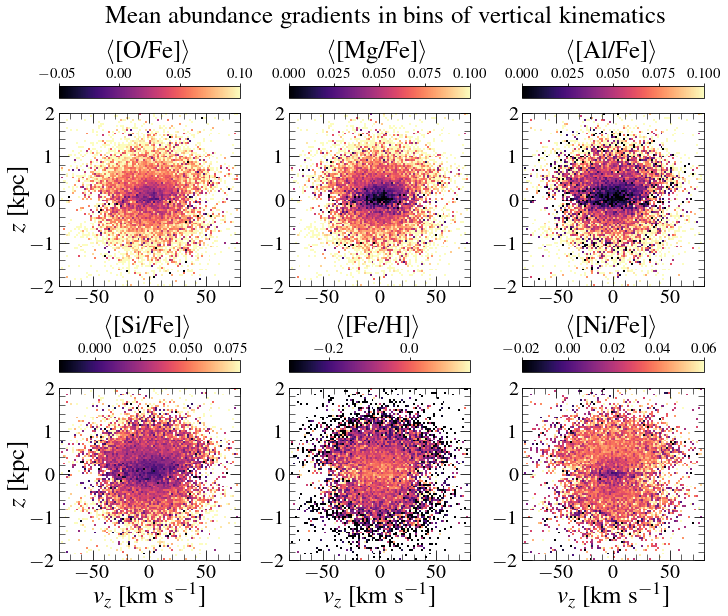

In [17]:
from scipy import stats

nbins=91
stat='mean'
fig = plt.figure(figsize=(10,8),constrained_layout=True,facecolor='white',rasterized=True)
fig.suptitle('Mean abundance gradients in bins of vertical kinematics',fontsize=25,x=0.53,y=1.05)
all_axes = []
for indx, i in enumerate(xfe):

    all_ax = plt.subplot(2,3,indx+1)
    all_axes.append(all_ax)
#     mask_plot = (Rg>8)&(Rg<10)
    abun = i
    binx = np.linspace(np.min(data['vxyz'][:,2][lowa_omask&(abun>-10)&rgbin]),np.max(data['vxyz'][:,2][lowa_omask&(abun>-10)&rgbin]),nbins)
    biny = np.linspace(np.min(data['xyz'][:,2][lowa_omask&(abun>-10)&rgbin]),np.max(data['xyz'][:,2][lowa_omask&(abun>-10)&rgbin]),nbins)    
    hist = stats.binned_statistic_2d(data['vxyz'][:,2][lowa_omask&(abun>-10)&rgbin],data['xyz'][:,2][lowa_omask&(abun>-10)&rgbin], i[lowa_omask&(abun>-10)&rgbin], statistic=stat, bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap='magma',vmin=vmins[indx],vmax=vmaxs[indx])
    plt.xlim(-80,80)
    plt.ylim(-2,2)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
    cbar.set_label(label=r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$',fontsize=25,labelpad=10)
    cbar.ax.tick_params(labelsize=15,pad=1)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

all_axes = np.reshape(all_axes,(2,3))
for ax in all_axes[:,0]:
    ax.set_ylabel('$z$ [kpc]', fontsize=25,labelpad=0.1)
for ax in all_axes[1,:]:
    ax.set_xlabel('$v_{z}$ [km s$^{-1}$]', fontsize=25,labelpad=0.1)
# plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/gradients-paper-Rg.pdf',dpi=200, bbox_inches = 'tight')




In [18]:
# now do it for all abundances

xfe=np.dstack([data['FE_H'],data['C_FE'],data['N_FE'],data['O_FE'],data['MG_FE'],data['AL_FE'],data['SI_FE'],data['MN_FE'],data['NI_FE'],data['CE_FE']])[0].T
xfe_labels = ['[Fe/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[Mn/Fe]','[Ni/Fe]','[Ce/Fe]']
vmins = [-0.3,-0.1,0.11,-0.02,0.0,-0.04,0.0,-0.04,-0.01,-0.3]
vmaxs = [0.15,0.05,0.28,0.12,0.12,0.12,0.06,0.07,0.05,0.1]



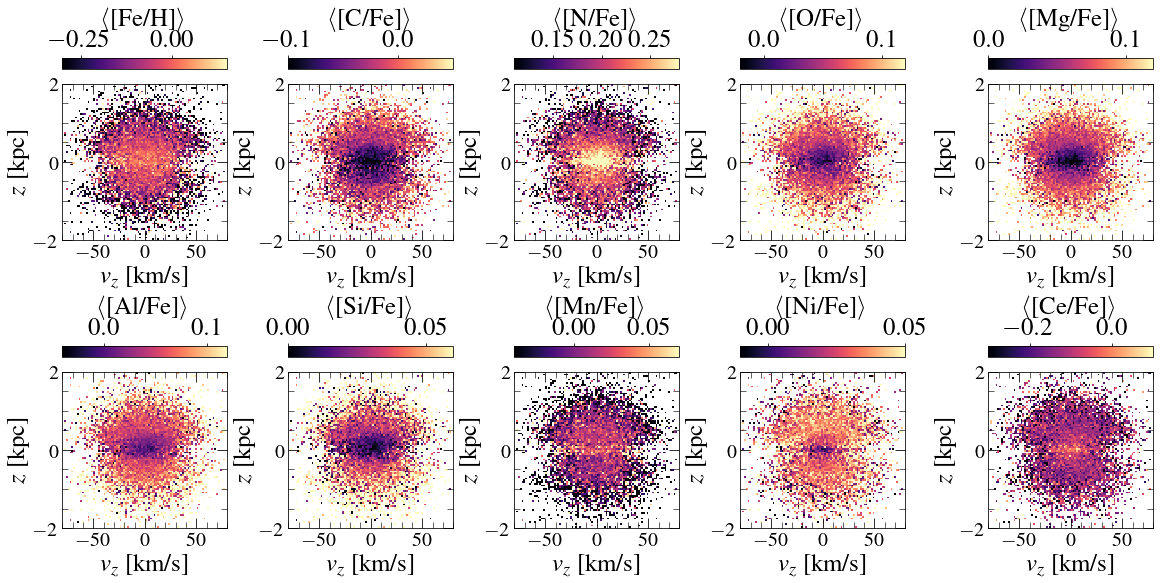

In [19]:

nbins=91
stat='mean'
fig = plt.figure(figsize=(16,8),constrained_layout=True,rasterized=True,facecolor='white')

for indx, i in enumerate(xfe):

    plt.subplot(2,5,indx+1)
    abun = i
    binx = np.linspace(np.min(data['vxyz'][:,2][lowa_omask&(abun>-10)&rgbin]),np.max(data['vxyz'][:,2][lowa_omask&(abun>-10)&rgbin]),nbins)
    biny = np.linspace(np.min(data['xyz'][:,2][lowa_omask&(abun>-10)&rgbin]),np.max(data['xyz'][:,2][lowa_omask&(abun>-10)&rgbin]),nbins)    
    hist = stats.binned_statistic_2d(data['vxyz'][:,2][lowa_omask&(abun>-10)&rgbin],data['xyz'][:,2][lowa_omask&(abun>-10)&rgbin], i[lowa_omask&(abun>-10)&rgbin], statistic=stat, bins=[binx,biny])
    plot_x, plot_y = np.meshgrid(binx,biny) 
    color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap='magma',vmin=vmins[indx],vmax=vmaxs[indx])
    plt.xlabel('$v_{z}$ [km/s]', fontsize=25)
    plt.ylabel('$z$ [kpc]', fontsize=25)
    plt.xlim(-80,80)
    plt.ylim(-2,2)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
    cbar.set_label(label=r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$',fontsize=25)
    cbar.ax.tick_params(labelsize=25)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
# plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/gradients_all.pdf',dpi=600, bbox_inches = 'tight')


Check for no systematics with stellar parameters

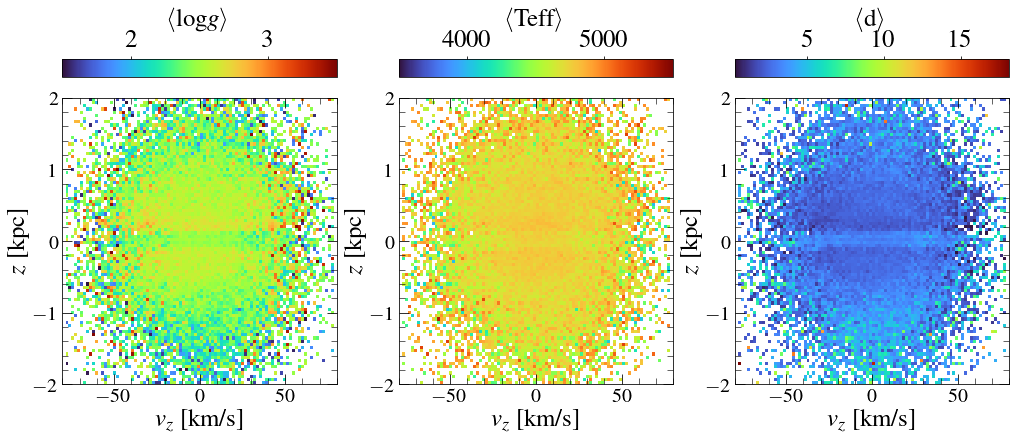

In [20]:

nbins=91
stat='mean'
fig = plt.figure(figsize=(14,6),constrained_layout=True,rasterized=True,facecolor='white')

plt.subplot(1,3,1)
binx = np.linspace(np.min(data['vxyz'][:,2][lowa_omask&(abun>-10)]),np.max(data['vxyz'][:,2][lowa_omask&(abun>-10)]),nbins)
biny = np.linspace(np.min(data['xyz'][:,2][lowa_omask&(abun>-10)]),np.max(data['xyz'][:,2][lowa_omask&(abun>-10)]),nbins)    
hist = stats.binned_statistic_2d(data['vxyz'][:,2][lowa_omask&(abun>-10)],data['xyz'][:,2][lowa_omask&(abun>-10)], data['LOGG'][lowa_omask&(abun>-10)], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=turbo,vmin=1.5,vmax=3.5)
plt.xlabel('$v_{z}$ [km/s]', fontsize=25)
plt.ylabel('$z$ [kpc]', fontsize=25)
plt.xlim(-80,80)
plt.ylim(-2,2)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$log$g$$\rangle$',fontsize=25)
cbar.ax.tick_params(labelsize=25)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.subplot(1,3,2)
binx = np.linspace(np.min(data['vxyz'][:,2][lowa_omask&(abun>-10)]),np.max(data['vxyz'][:,2][lowa_omask&(abun>-10)]),nbins)
biny = np.linspace(np.min(data['xyz'][:,2][lowa_omask&(abun>-10)]),np.max(data['xyz'][:,2][lowa_omask&(abun>-10)]),nbins)    
hist = stats.binned_statistic_2d(data['vxyz'][:,2][lowa_omask&(abun>-10)],data['xyz'][:,2][lowa_omask&(abun>-10)], data['TEFF'][lowa_omask&(abun>-10)], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=turbo,vmin=3500,vmax=5500)
plt.xlabel('$v_{z}$ [km/s]', fontsize=25)
plt.ylabel('$z$ [kpc]', fontsize=25)
plt.xlim(-80,80)
plt.ylim(-2,2)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$Teff$\rangle$',fontsize=25)
cbar.ax.tick_params(labelsize=25)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')



plt.subplot(1,3,3)
binx = np.linspace(np.min(data['vxyz'][:,2][lowa_omask&(abun>-10)]),np.max(data['vxyz'][:,2][lowa_omask&(abun>-10)]),nbins)
biny = np.linspace(np.min(data['xyz'][:,2][lowa_omask&(abun>-10)]),np.max(data['xyz'][:,2][lowa_omask&(abun>-10)]),nbins)    
hist = stats.binned_statistic_2d(data['vxyz'][:,2][lowa_omask&(abun>-10)],data['xyz'][:,2][lowa_omask&(abun>-10)],data['dist50'][lowa_omask&(abun>-10)], statistic=stat, bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=turbo)
plt.xlabel('$v_{z}$ [km/s]', fontsize=25)
plt.ylabel('$z$ [kpc]', fontsize=25)
plt.xlim(-80,80)
plt.ylim(-2,2)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'$\langle$d$\rangle$',fontsize=25)
cbar.ax.tick_params(labelsize=25)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
